# ETH Staking Statistics and Comparison with SP500

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical packages
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# For lead-lag analysis
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.regression.linear_model import OLS

# Data collection
import requests
import yfinance as yf

import warnings

%reload_ext autoreload
%autoreload 2
%matplotlib inline

warnings.filterwarnings("ignore", category=FutureWarning)

## Data Collection

You can skip this part, and go to the next section `Load Data` as I saved the data locally after querying.

In [2]:
# Configuration
START_DATE = '2024-01-01'
END_DATE = '2025-10-31'

In [ ]:
sp500 = (
    yf.download('^GSPC', start=START_DATE, end=END_DATE, interval='1h', progress=False)
    .loc[:, ['Close']]
)
sp500.columns = sp500.columns.droplevel(1)
sp500.columns.name = None
sp500.name = 'SPY'

/var/folders/c8/q5_vzv354fl3s9gzzn9mzm_h0000gn/T/ipykernel_83583/2948775626.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download('^GSPC', start=START_DATE, end=END_DATE, interval='1h', progress=False)


In [4]:
interval = "30m"
interval_ms = 30 * 60 * 1000  # 30 minutes in milliseconds
base_url = "https://api.binance.com/api/v3"

def fetch_klines(symbol, start_ts, end_ts, interval_ms):
    all_klines = []
    curr_start = start_ts
    while curr_start < end_ts:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": curr_start,
            "endTime": end_ts,
            "limit": 1000
        }
        resp = requests.get(f"{base_url}/klines", params=params)
        klines = resp.json()
        if not klines:
            break
        all_klines.extend(klines)
        last_open = int(klines[-1][0])
        curr_start = last_open + interval_ms
    cols = [
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "num_trades",
        "taker_buy_base", "taker_buy_quote", "ignore"
    ]
    df = pd.DataFrame(all_klines, columns=cols)
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms", utc=True)
    df["close"] = pd.to_numeric(df["close"], errors="coerce")
    df["volume"] = pd.to_numeric(df["volume"], errors="coerce")
    df_clean = (
        df[["open_time", "close"]]
        .rename(columns={"open_time": "time", "close": "close_price"})
        .set_index("time")
        .sort_index()
    )
    return df_clean


start_ts = int(pd.to_datetime(START_DATE).tz_localize("UTC").timestamp() * 1000)
end_ts = int(pd.to_datetime(END_DATE).tz_localize("UTC").timestamp() * 1000)

wbeth_df = fetch_klines("WBETHETH", start_ts, end_ts, interval_ms)
eth_df = fetch_klines("ETHUSDC", start_ts, end_ts, interval_ms)

wbeth_aligned = wbeth_df.reindex(sp500.index).rename(columns={"close_price": "Close"})
eth_aligned = eth_df.reindex(sp500.index).rename(columns={"close_price": "Close"})

I created a dune query https://dune.com/queries/6118742 to obtain the total amount of staked Eth.

In [ ]:
import os
import requests

API_KEY = os.getenv("DUNE_API")
url = "https://api.dune.com/api/v1/query/6118742/results?limit=40000"

headers = {
    "X-Dune-API-Key": API_KEY
}

response = requests.get(url, headers=headers).json()
staked_eth_qty = pd.DataFrame(response['result']['rows'])
staked_eth_qty['time'] = pd.to_datetime(staked_eth_qty['time'])
staked_eth_qty = staked_eth_qty.sort_values('time').reset_index(drop=True)
staked_eth_qty.columns = ['Datetime', 'staked_eth_qty']
staked_eth_qty = staked_eth_qty.set_index('Datetime')
staked_eth_qty_aligned = staked_eth_qty.reindex(sp500.index)

In [6]:
common_index = sp500.dropna().index.intersection(wbeth_aligned.dropna().index).intersection(staked_eth_qty_aligned.dropna().index).intersection(eth_aligned.dropna().index)
sp500 = sp500.loc[common_index]
wbeth_aligned = wbeth_aligned.loc[common_index]
eth_aligned = eth_aligned.loc[common_index]
staked_eth_qty_aligned = staked_eth_qty_aligned.loc[common_index]

In [9]:
# Save data
sp500.to_csv("data/sp500.csv")
wbeth_aligned.to_csv("data/wbeth_eth.csv")
eth_aligned.to_csv("data/eth_usdc.csv")
staked_eth_qty_aligned.to_csv("data/staked_eth_qty.csv")

# Load data

In [14]:
sp500 = pd.read_csv("data/sp500.csv", index_col=0, parse_dates=True).squeeze()
wbeth_eth = pd.read_csv("data/wbeth_eth.csv", index_col=0, parse_dates=True).squeeze()
eth_usdc = pd.read_csv("data/eth_usdc.csv", index_col=0, parse_dates=True).squeeze()
staked_eth_qty = pd.read_csv("data/staked_eth_qty.csv", index_col=0, parse_dates=True).squeeze()

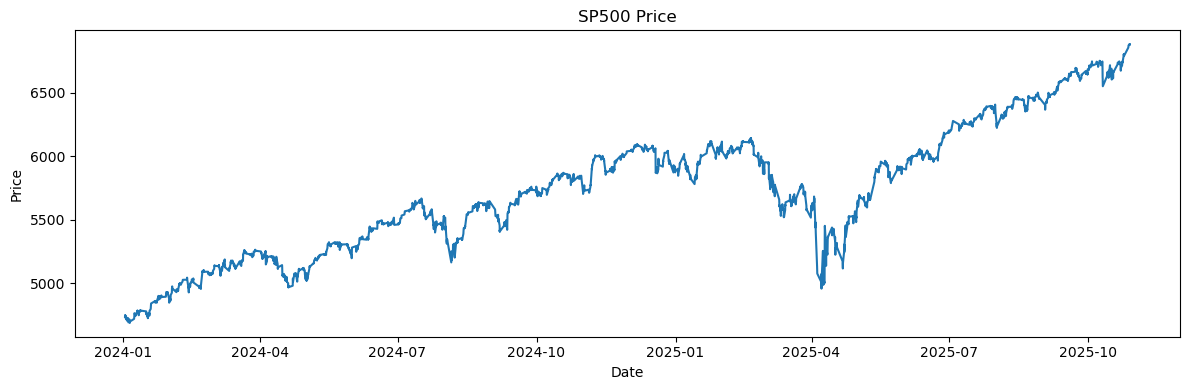

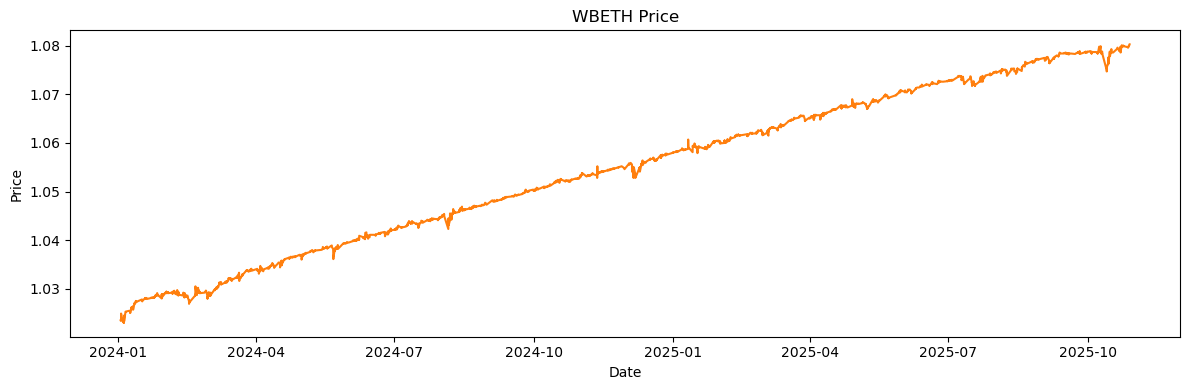

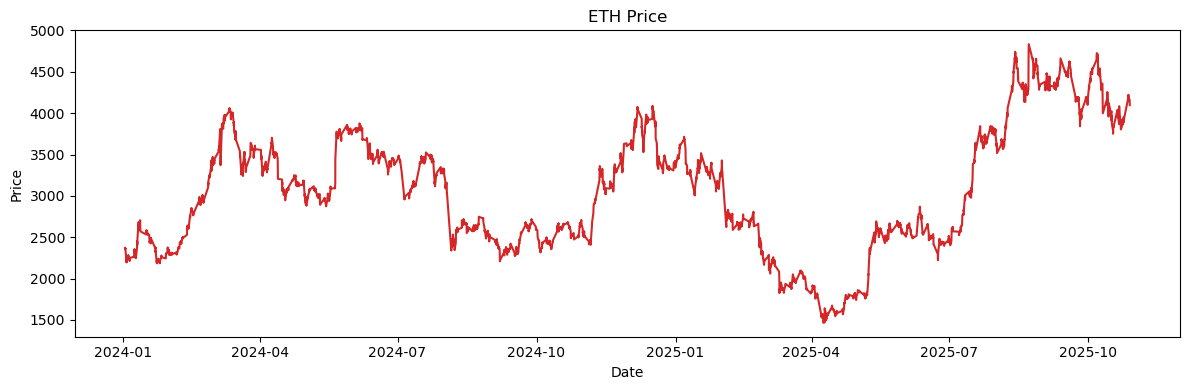

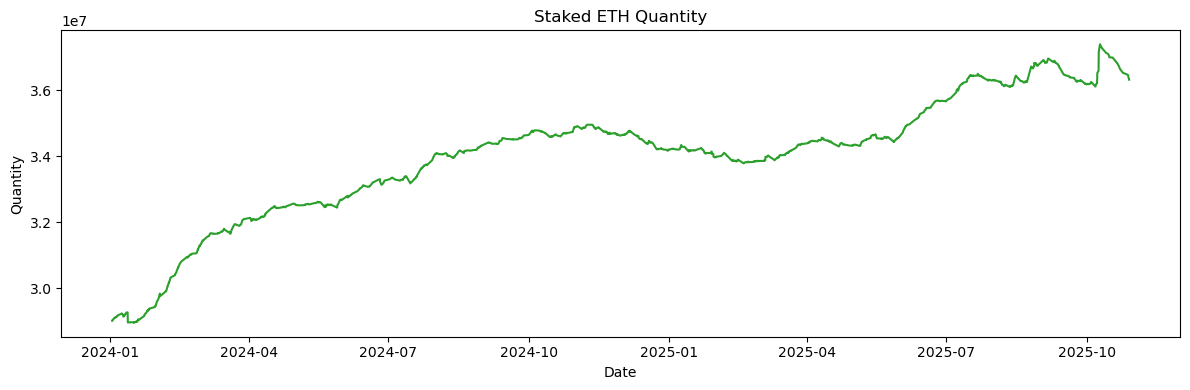

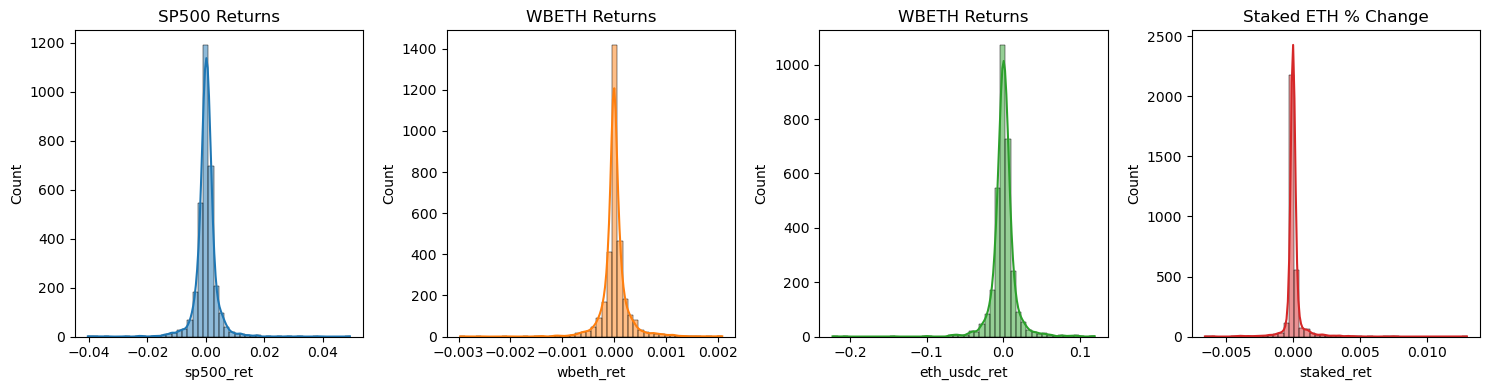

In [25]:
sp500_ret = sp500.pct_change().fillna(0).rename('sp500_ret')
wbeth_ret = wbeth_eth.pct_change().fillna(0).rename('wbeth_ret')
eth_usdc_ret = eth_usdc.pct_change().fillna(0).rename('eth_usdc_ret')
staked_ret = staked_eth_qty.pct_change().fillna(0).rename('staked_ret')

# SP500
plt.figure(figsize=(12,4))
plt.plot(sp500.index, sp500, color='tab:blue')
plt.title('SP500 Price')
plt.ylabel('Price')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# WBETH
plt.figure(figsize=(12,4))
plt.plot(wbeth_eth.index, wbeth_eth, color='tab:orange')
plt.title('WBETH Price')
plt.ylabel('Price')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# ETH
plt.figure(figsize=(12,4))
plt.plot(eth_usdc.index, eth_usdc, color='tab:red')
plt.title('ETH Price')
plt.ylabel('Price')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Staked ETH
plt.figure(figsize=(12,4))
plt.plot(staked_eth_qty.index, staked_eth_qty, color='tab:green')
plt.title('Staked ETH Quantity')
plt.ylabel('Quantity')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# -------------------------------
# Return distributions
# -------------------------------
fig, axes = plt.subplots(1, 4, figsize=(15,4))

sns.histplot(sp500_ret.dropna(), bins=50, kde=True, ax=axes[0], color='C0')
axes[0].set_title('SP500 Returns')

sns.histplot(wbeth_ret.dropna(), bins=50, kde=True, ax=axes[1], color='C1')
axes[1].set_title('WBETH Returns')

sns.histplot(eth_usdc_ret.dropna(), bins=50, kde=True, ax=axes[2], color='C2')
axes[2].set_title('WBETH Returns')

sns.histplot(staked_ret.dropna(), bins=50, kde=True, ax=axes[3], color='C3')
axes[3].set_title('Staked ETH % Change')

plt.tight_layout()
plt.show()

## Cointegration Analysis

We'll test for cointegration on the price levels rather than returns, as returns tend to be stationary and will yield artificially positive results.


In [42]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools
from statsmodels.tsa.vector_ar.vecm import coint_johansen

df = pd.concat([
    staked_eth_qty.rename('Staked_ETH_Qty'),
    wbeth_eth.rename('WBETH/USDC'),
    eth_usdc.rename('ETH/USDC'),
    sp500.rename('SP500')
], axis=1)


print("=== Engle-Granger Pairwise Cointegration ===")
series_names = df.columns
for s1, s2 in itertools.combinations(series_names, 2):
    X = sm.add_constant(df[s2].dropna())
    Y = df[s1].dropna()
    common_index = X.index.intersection(Y.index)
    X, Y = X.loc[common_index], Y.loc[common_index]
    
    model = sm.OLS(Y, X).fit()
    residuals = model.resid
    
    adf_res = adfuller(residuals)
    
    print(f"{s1} ~ {s2}: ADF p-value = {adf_res[1]:.4f}")

print("\n=== Johansen Cointegration Test ===")
coint_res = coint_johansen(df.values, det_order=0, k_ar_diff=1)
print("Eigenvalues:", coint_res.eig)
print("Trace statistic:", coint_res.lr1)
print("Critical values (90%, 95%, 99%):\n", coint_res.cvt)

=== Engle-Granger Pairwise Cointegration ===
Staked_ETH_Qty ~ WBETH/USDC: ADF p-value = 0.1289
Staked_ETH_Qty ~ ETH/USDC: ADF p-value = 0.1521
Staked_ETH_Qty ~ SP500: ADF p-value = 0.0460
WBETH/USDC ~ ETH/USDC: ADF p-value = 0.6448
WBETH/USDC ~ SP500: ADF p-value = 0.2531
ETH/USDC ~ SP500: ADF p-value = 0.2567

=== Johansen Cointegration Test ===
Eigenvalues: [0.00577622 0.00402335 0.00098041 0.00032096]
Trace statistic: [35.42623218 16.98142811  4.145247    1.02209696]
Critical values (90%, 95%, 99%):
 [[44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


Pairwise Engle-Granger tests show tht only Staked ETH Quantity and the SP500 exhibit weak evidence of cointegration (p = 0.046), while all other pairs are not cointegrated. The Johansen test for all four series together also confrms this, as the trace statistics are below the 95% critical values with very small eigenvalues. Next, we will conduct some lead-lag analysis.


## Lead-Lag Relationship Analysis
For the lead-lag analysis, we will consider the returns instead, i.e. staked quantity changes, staking yield, ETH returns, and SP500 returns.


In [51]:
sp500_ret = sp500.pct_change().fillna(0).rename('sp500_ret')
staked_yield = wbeth_eth.pct_change().fillna(0).rename('staked_yield')
eth_usdc_ret = eth_usdc.pct_change().fillna(0).rename('eth_usdc_ret')
staked_qty_change = staked_eth_qty.pct_change().fillna(0).rename('staked_qty_change')

returns_df = pd.concat([
    sp500_ret,
    staked_yield,
    eth_usdc_ret,
    staked_qty_change
], axis=1).dropna()

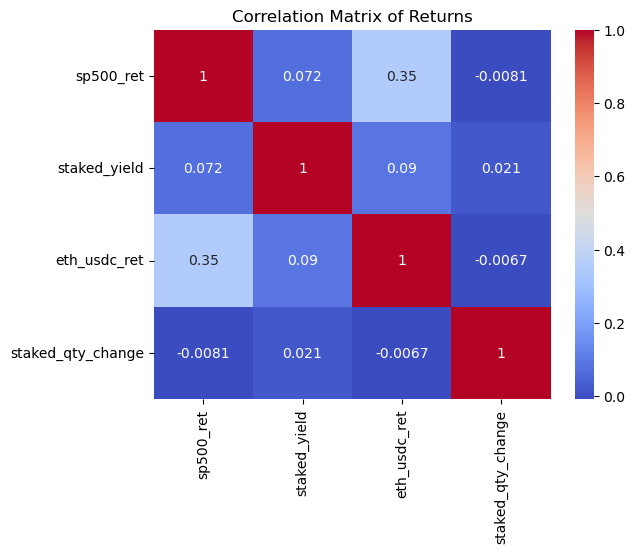

In [48]:
sns.heatmap(returns_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Returns')
plt.show()

In [80]:

lags = 10  # number of periods to test
pairs = list(itertools.combinations(returns_df.columns, 2))

# DataFrame to store all correlations
lead_lag_corr_all = {}

for s1, s2 in pairs:
    # Compute correlation at lags -10 to 10
    corr = [returns_df[s1].corr(returns_df[s2].shift(lag)) for lag in range(-lags, lags+1)]
    lead_lag_corr_all[f"{s1} ~ {s2}"] = corr

# Convert to DataFrame
lead_lag_corr_df = pd.DataFrame(lead_lag_corr_all, index=range(-lags, lags+1))

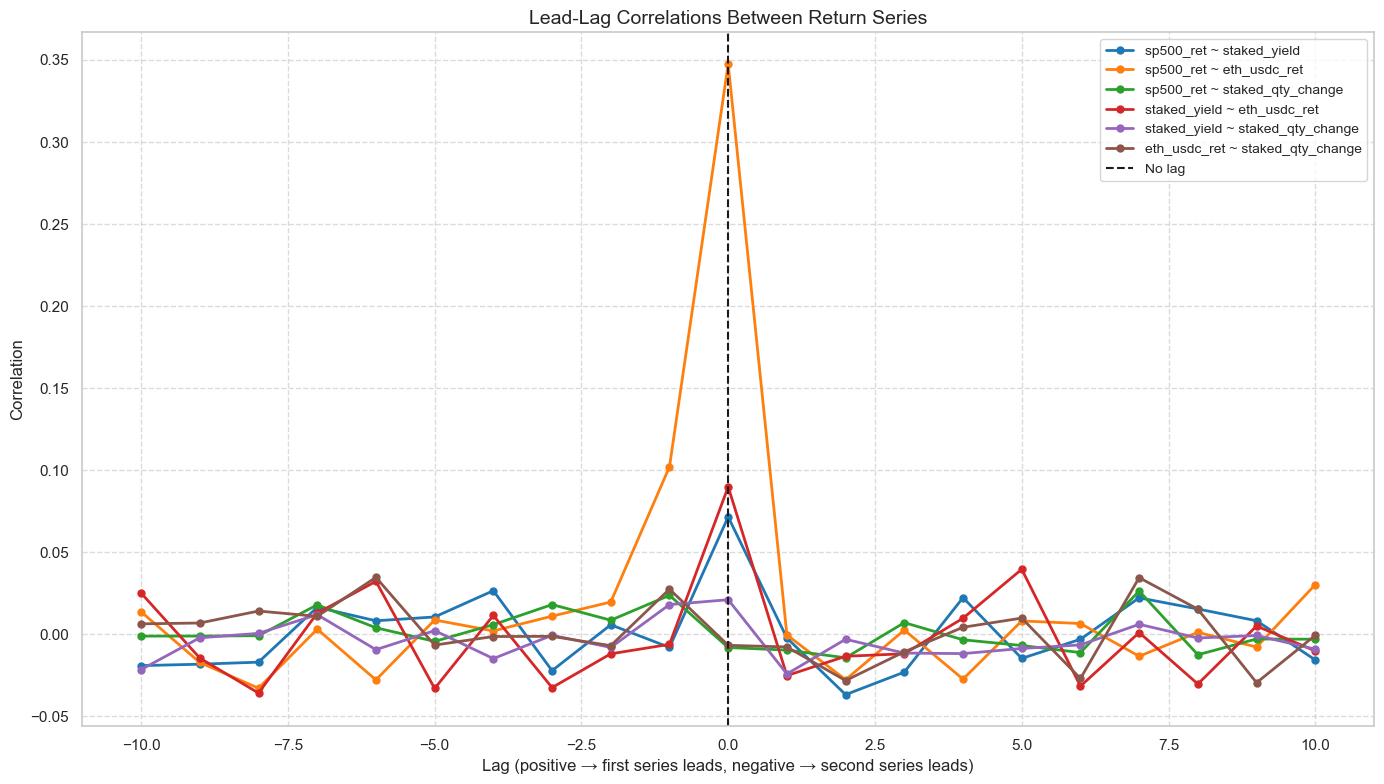

In [81]:
plt.figure(figsize=(14, 8))

palette = sns.color_palette("tab10", n_colors=len(lead_lag_corr_df.columns))

for i, col in enumerate(lead_lag_corr_df.columns):
    plt.plot(
        lead_lag_corr_df.index,
        lead_lag_corr_df[col],
        marker='o',
        linewidth=2,
        markersize=5,
        label=col,
        color=palette[i % len(palette)]
    )

plt.axvline(0, color='k', linestyle='--', linewidth=1.5, label='No lag')
plt.xlabel("Lag (positive → first series leads, negative → second series leads)", fontsize=12)
plt.ylabel("Correlation", fontsize=12)
plt.title("Lead-Lag Correlations Between Return Series", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Legend: remove duplicates and adjust font size
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()


From the plot, we can see there is some lead-lag correlation in the first lag between `sp500` and `eth_usdc`, where `eth/usdc` returns lead the `sp500` .

In [71]:
from statsmodels.tsa.stattools import grangercausalitytests

max_lag = 5
pairs = list(itertools.combinations(returns_df.columns, 2))
records = []

for s1, s2 in pairs:
    test = grangercausalitytests(returns_df[[s2, s1]], maxlag=max_lag, verbose=False)
    for lag in range(1, max_lag+1):
        pval = test[lag][0]['ssr_ftest'][1]
        records.append({"Cause": s1, "Effect": s2, "Lag": lag, "p_value": pval})

    test_rev = grangercausalitytests(returns_df[[s1, s2]], maxlag=max_lag, verbose=False)
    for lag in range(1, max_lag+1):
        pval = test_rev[lag][0]['ssr_ftest'][1]
        records.append({"Cause": s2, "Effect": s1, "Lag": lag, "p_value": pval})

granger_df = pd.DataFrame(records)
granger_df['Significant'] = granger_df['p_value'] < 0.05

display(granger_df[granger_df['Significant']])

,Cause,Effect,Lag,p_value,Significant
10,sp500_ret,eth_usdc_ret,1,7.984618e-10,True
11,sp500_ret,eth_usdc_ret,2,1.650695e-09,True
12,sp500_ret,eth_usdc_ret,3,6.533282e-09,True
13,sp500_ret,eth_usdc_ret,4,2.545300e-08,True
14,sp500_ret,eth_usdc_ret,5,6.782441e-08,True


On the other hand the granger causality test suggests that there is some relationship where sp500 leads eth. To analyze this further, we will take a look at upswing and downswing periods. For this we have to define an upswing and a downsing. We will take the rolling mean over the benchmark returns (for smoothness) and check if this exceeds the standard deviation of the returns of the benchmark. 

 Number of intersections with no NaNs: 261
 Number of intersections with no NaNs: 261
 Number of intersections with no NaNs: 261
 Number of intersections with no NaNs: 261
 Number of intersections with no NaNs: 261
 Number of intersections with no NaNs: 261


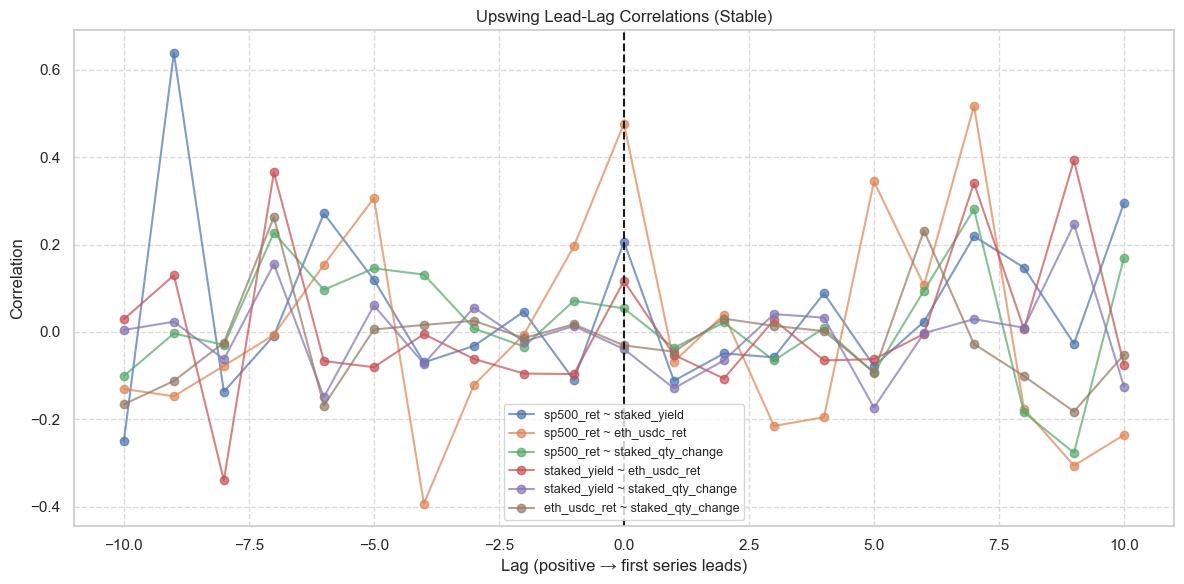

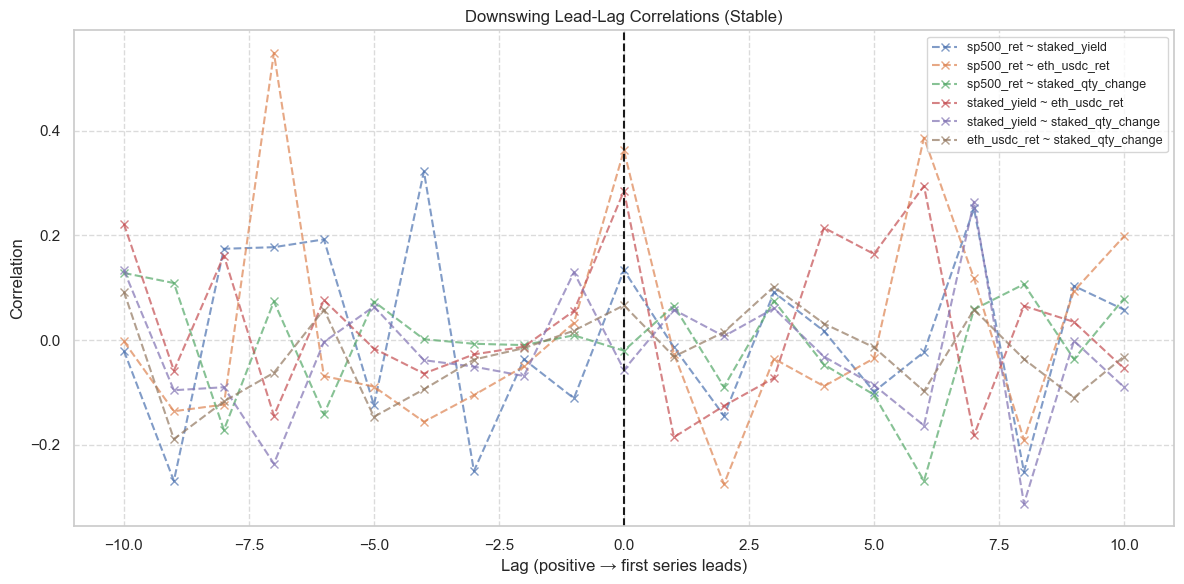

In [ ]:
def lead_lag(returns_df, benchmark, lags=10, window=5, std_factor=2):
    """
    Lead-lag correlation analysis:
    - Uses short rolling cumulative return to define up/down periods
    - Threshold based on global std of rolling cumulative return
    """
    # 1. Rolling cumulative return (short-term momentum)
    rolling_cum = returns_df[benchmark].rolling(window).mean()
    
    # 2. Define thresholds using global std
    threshold = std_factor * rolling_cum.std()
    upswing_mask = rolling_cum > threshold
    downswing_mask = rolling_cum < -threshold
    
    # 3. Mask returns
    upswing_df = returns_df.copy()
    downswing_df = returns_df.copy()
    upswing_df.loc[~upswing_mask] = pd.NA
    downswing_df.loc[~downswing_mask] = pd.NA
    
    # 4. Compute lead-lag correlations
    pairs = list(itertools.combinations(returns_df.columns, 2))
    lead_lag_up = {}
    lead_lag_down = {}
    
    for s1, s2 in pairs:
        corr_up = [upswing_df[s1].corr(upswing_df[s2].shift(lag)) for lag in range(-lags, lags+1)]
        lead_lag_up[f"{s1} ~ {s2}"] = corr_up
        
        corr_down = [downswing_df[s1].corr(downswing_df[s2].shift(lag)) for lag in range(-lags, lags+1)]
        lead_lag_down[f"{s1} ~ {s2}"] = corr_down
    
    lead_lag_corr_up_df = pd.DataFrame(lead_lag_up, index=range(-lags, lags+1))
    lead_lag_corr_down_df = pd.DataFrame(lead_lag_down, index=range(-lags, lags+1))
    
    
    # Upswing
    plt.figure(figsize=(12,6))
    for col in lead_lag_corr_up_df.columns:
        plt.plot(lead_lag_corr_up_df.index, lead_lag_corr_up_df[col], marker='o', alpha=0.7, label=col)
    plt.axvline(0, color='k', linestyle='--', linewidth=1.5)
    plt.title("Upswing Lead-Lag Correlations (Stable)")
    plt.xlabel("Lag (positive → first series leads)")
    plt.ylabel("Correlation")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=9)
    plt.tight_layout()
    plt.show()
    
    # Downswing
    plt.figure(figsize=(12,6))
    for col in lead_lag_corr_down_df.columns:
        plt.plot(lead_lag_corr_down_df.index, lead_lag_corr_down_df[col], marker='x', linestyle='--', alpha=0.7, label=col)
    plt.axvline(0, color='k', linestyle='--', linewidth=1.5)
    plt.title("Downswing Lead-Lag Correlations (Stable)")
    plt.xlabel("Lag (positive → first series leads)")
    plt.ylabel("Correlation")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=9)
    plt.tight_layout()
    plt.show()
    
    return lead_lag_corr_up_df, lead_lag_corr_down_df


lead_lag(
    returns_df,
    benchmark='sp500_ret',
    lags=10,
    window=5,
    std_factor=1
);

There seem to be quite pronounced lead-lag effects during upswings and downsings of the sp500. However, the correlations are quite high and I remain a bit sceptical given the magnitude of the correlations. Especially noticeable during the upswing is at the -9th lag etween sp500 returns and staked yield. This seems to suggest that staked yield may lead the sp500 returns 9 hours ahead, i.e. when there are high returns in staking yield, sp500 would also follow. Simarlarly during downswings, eth in the 6th lag seems to also lead sp500. I don't really see an economical explanation for this.

However, I think it would make sense that during periods of upswings for ETH that the staking quantity increases and vice versa. So let's test this hypothesis.

 Number of intersections with no NaNs: 327
 Number of intersections with no NaNs: 327
 Number of intersections with no NaNs: 327
 Number of intersections with no NaNs: 327
 Number of intersections with no NaNs: 327
 Number of intersections with no NaNs: 327


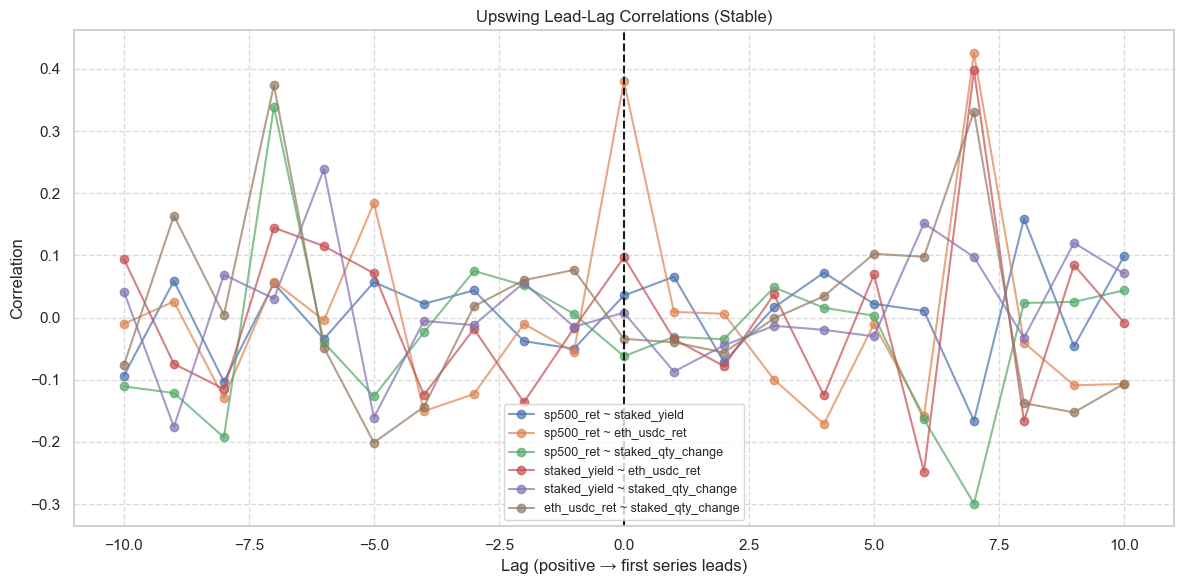

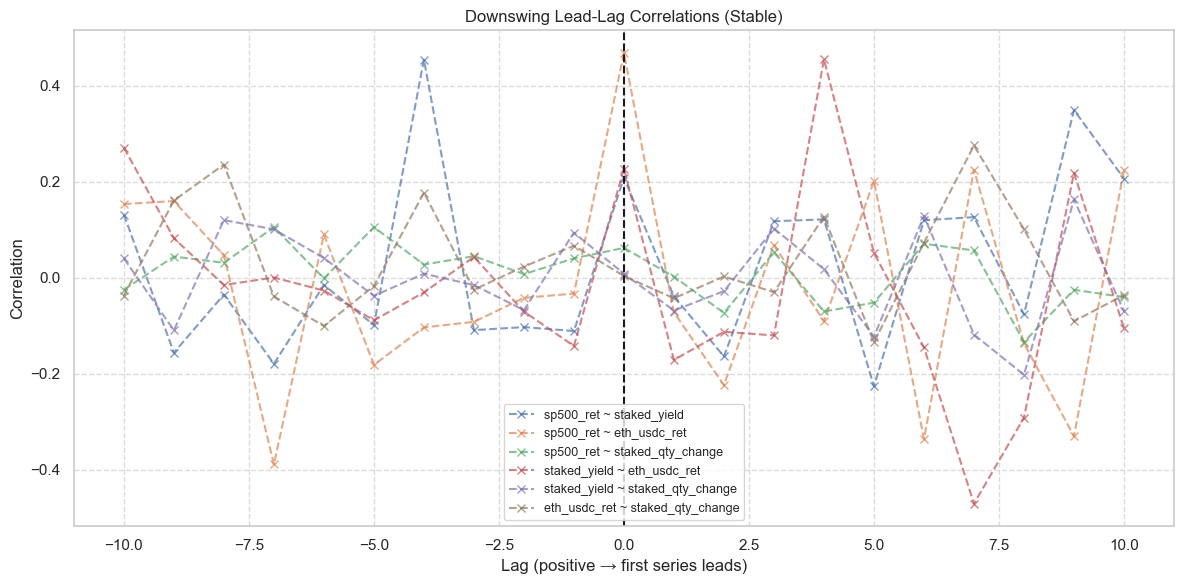

In [106]:

lead_lag(
    returns_df,
    benchmark='eth_usdc_ret',
    lags=10,
    window=5,
    std_factor=1
);

Although it is not the most promiment, this one can see in the -7th lag during upswings of `eth_usdc_ret/staked_qty_change` and the 7th lag that there is high positive correlation, which I think makes sense, as the negative lag suggests that people may anticipate the upswing and in the positive lag, people stake more following an upswing of eth. 